In [62]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

### solve differential equation and produce dataset for modeling 

In [63]:
t_start = 0
t_stop = 180
increment = 0.001

x_init = [0, 0]
t = np.arange(t_start, t_stop + 1, increment)

def differential_equation(x, t, F, W):
    M = 1
    D = 0.05
#     K = 1+0.1*x[0]
    FE = F*np.sin(W*t)
    # x[0] = position
    # x[1] = velocity
    dx1dt = x[1]
    dx2dt = (FE - D*x[1] - x[0]- 0.1*x[0]*x[0])
    
    dxdt = [dx1dt, dx2dt]
    
    return dxdt

In [64]:
x = odeint(func=differential_equation, y0=x_init, t=t, args=(0.1, 0.1))

In [65]:
position = x[:, 0]
velocity = x[:, 1]

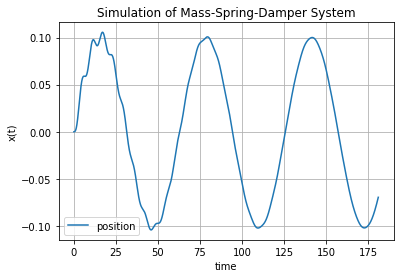

In [66]:
plt.plot(t, position)
# plt.plot(t, velocity)
plt.title('Simulation of Mass-Spring-Damper System')
plt.xlabel('time')
plt.ylabel('x(t)')
plt.legend(["position", "velocity"])
plt.grid()
plt.show()

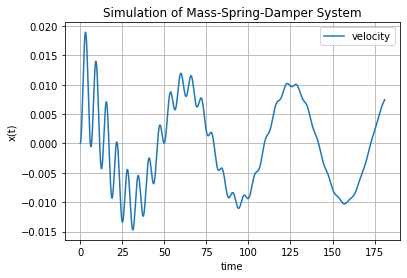

In [67]:
# plt.plot(t, position)
plt.plot(t, velocity)
plt.title('Simulation of Mass-Spring-Damper System')
plt.xlabel('time')
plt.ylabel('x(t)')
plt.legend(["velocity"])
plt.grid()
plt.show()

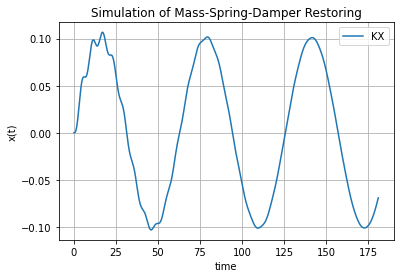

In [68]:
KX = (1+0.1*position)*position
plt.plot(t, KX)
plt.title('Simulation of Mass-Spring-Damper Restoring')
plt.xlabel('time')
plt.ylabel('x(t)')
plt.legend(["KX"])
plt.grid()
plt.show()

#### Produce Dataset 

In [4]:
dataset = list()
for F in np.arange(0.1, 10, 0.1):
    for W in np.arange(0.1, 10, 0.1):
        tmp = dict()
        x = odeint(func=differential_equation, y0=x_init, t=t, args=(F, W))
        position = x[:, 0]
        K = (1+0.1*position)
        KX = (1+0.1*position)*position
        tmp["F"] = F
        tmp["W"] = W
        tmp["max_K"] = np.max(K)
        tmp["max_KX"] = np.max(KX)
        dataset.append(tmp)
        

C:\Users\Kian\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [5]:
import pandas as pd
pd.DataFrame(dataset).to_csv("mass_spring_damper_dataset.csv", index=None)

###  Dataset cleaning & Neural Network Design

In [1]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import pearsonr
import pandas as pd
import numpy as np

In [2]:
scaler = StandardScaler()
minmax = MinMaxScaler()

In [3]:
pearson = lambda x,y: pearsonr(x,y)[0]

In [4]:
dataset = pd.read_csv("mass_spring_damper_dataset.csv").astype('float64')

In [5]:
dataset.astype(float)

,F,W,max_K,max_KX
0,0.1,0.1,1.010564,0.106755
1,0.1,0.2,1.010484,0.105941
2,0.1,0.3,1.013629,0.138145
3,0.1,0.4,1.015549,0.157908
4,0.1,0.5,1.016539,0.168125
...,...,...,...,...
9796,9.9,9.5,1.104147,1.149937
9797,9.9,9.6,1.103443,1.141438
9798,9.9,9.7,1.102815,1.133863
9799,9.9,9.8,1.102160,1.125965


In [6]:
dataset.max_KX.describe()

count    9.801000e+03
mean     3.572955e+51
std      2.052252e+53
min      1.067958e-02
25%      5.998268e-01
50%      1.246869e+00
75%      3.503637e+00
max      1.867239e+55
Name: max_KX, dtype: float64

<AxesSubplot:>

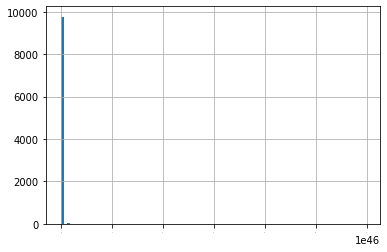

In [21]:
dataset.max_KX.hist(bins=100)

<AxesSubplot:>

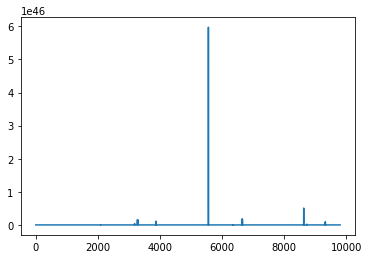

In [18]:
dataset.max_KX.plot.line()

### detect outliers (based on non-stable output) 

In [47]:
def func(x):
    if x < 4:
        return 0
    else:
        return 1
dataset["is_outlier"] = dataset.max_KX.apply(func)

No handles with labels found to put in legend.


 yellow: non-stable 
 purple: stable


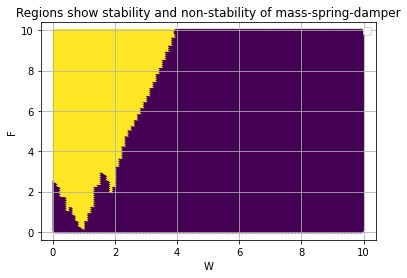

In [71]:
import matplotlib.pyplot as plt

print(" yellow: non-stable", "\n", "purple: stable")
plt.scatter(dataset.W, dataset.F, c=dataset.is_outlier)
plt.title('Regions show stability and non-stability of mass-spring-damper')
plt.xlabel('W')
plt.ylabel('F')
plt.legend()
plt.grid()
plt.show()

Text(0.5, 0, 'F')

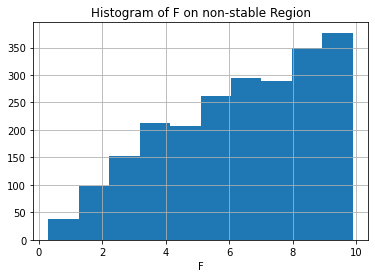

In [72]:
outliers.F.hist()
plt.title("Histogram of F on non-stable Region")
plt.xlabel("F")

Text(0.5, 0, 'W')

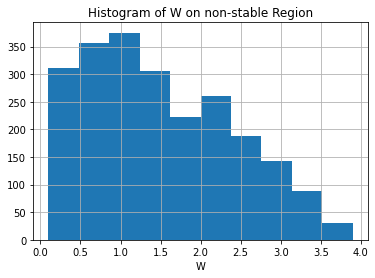

In [73]:
outliers.W.hist()
plt.title("Histogram of W on non-stable Region")
plt.xlabel("W")

### remove non-stable regions from dataset
- number 4 is select from 75% quartile
- 4 is a little greater than 75% of max_KX

In [7]:
outliers = dataset[dataset.max_KX > 4]
clean_dataset = dataset[~(dataset.max_KX > 4)]

#### Predict maximum of KX Based on Neural Network  

In [163]:
import tensorflow as tf

def nn_model():
    
    model = Sequential()
    model.add(layers.Dense(5, activation=K.relu))
    model.add(layers.Dense(16, activation=K.relu))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(1, activation=K.relu))
    
    model.compile(loss="mae", optimizer="adam", metrics=["mse"])
    return model

In [171]:
kfold = KFold(n_splits=5, shuffle=True, random_state=7)

result = list()

for train_index, test_index in kfold.split(clean_dataset):
    train_data = clean_dataset.iloc[train_index]
    test_data = clean_dataset.iloc[test_index]
    
    train_label = train_data[["max_KX"]].to_numpy(dtype='float64')
    test_label = test_data[["max_KX"]].to_numpy(dtype='float64')
        
    model = nn_model()
    model.fit(train_data[["F", "W"]].to_numpy(dtype='float64'),
              train_label,
              validation_data=(test_data[["F", "W"]].to_numpy(dtype='float64'), test_label),
              epochs=20, 
              batch_size=8
             )
    result.append(model.history.history)
    

Epoch 1/20
752/752 [==============================] - 1s 1ms/step - loss: 0.6719 - mse: 0.9154 - val_loss: 0.2932 - val_mse: 0.2746
Epoch 2/20
752/752 [==============================] - 1s 955us/step - loss: 0.2887 - mse: 0.2582 - val_loss: 0.1989 - val_mse: 0.1454
Epoch 3/20
752/752 [==============================] - 1s 980us/step - loss: 0.2231 - mse: 0.1524 - val_loss: 0.1641 - val_mse: 0.0914
Epoch 4/20
752/752 [==============================] - 1s 974us/step - loss: 0.1988 - mse: 0.1222 - val_loss: 0.1317 - val_mse: 0.0687
Epoch 5/20
752/752 [==============================] - 1s 941us/step - loss: 0.1948 - mse: 0.1176 - val_loss: 0.1303 - val_mse: 0.0619
Epoch 6/20
752/752 [==============================] - 1s 964us/step - loss: 0.1814 - mse: 0.0997 - val_loss: 0.1351 - val_mse: 0.0618
Epoch 7/20
752/752 [==============================] - 1s 959us/step - loss: 0.1837 - mse: 0.1030 - val_loss: 0.1221 - val_mse: 0.0538
Epoch 8/20
752/752 [==============================] - 1s 975us/s

753/753 [==============================] - 1s 1ms/step - loss: 0.4407 - mse: 0.4283 - val_loss: 0.3606 - val_mse: 0.3777
Epoch 3/20
753/753 [==============================] - 1s 1ms/step - loss: 0.3285 - mse: 0.2791 - val_loss: 0.2813 - val_mse: 0.2356
Epoch 4/20
753/753 [==============================] - 1s 1ms/step - loss: 0.2983 - mse: 0.2229 - val_loss: 0.2683 - val_mse: 0.2020
Epoch 5/20
753/753 [==============================] - 1s 1ms/step - loss: 0.2899 - mse: 0.2066 - val_loss: 0.2650 - val_mse: 0.1905
Epoch 6/20
753/753 [==============================] - 1s 1ms/step - loss: 0.2879 - mse: 0.1988 - val_loss: 0.2574 - val_mse: 0.1829
Epoch 7/20
753/753 [==============================] - 1s 994us/step - loss: 0.2869 - mse: 0.1909 - val_loss: 0.2498 - val_mse: 0.1634
Epoch 8/20
753/753 [==============================] - 1s 989us/step - loss: 0.2803 - mse: 0.1838 - val_loss: 0.2510 - val_mse: 0.1681
Epoch 9/20
753/753 [==============================] - 1s 1ms/step - loss: 0.2816 - 

### regression report


In [172]:

print(
f"""
cv=5  train mse: {np.mean([e["mse"][-1] for e in result])}
cv=5  validation mse: {np.mean([e["val_mse"][-1] for e in result])}

cv=5  train mae: {np.mean([e["loss"][-1] for e in result])}
cv=5  validation mae: {np.mean([e["val_loss"][-1] for e in result])}
"""
)


cv=5  train mse: 0.11309524029493331
cv=5  validation mse: 0.06349961534142494

cv=5  train mae: 0.19530483186244965
cv=5  validation mae: 0.1327104389667511



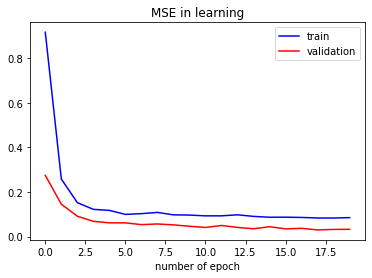

In [173]:
plt.plot(result[0]["mse"], 'b')
plt.plot(result[0]["val_mse"], 'r')
plt.xlabel("number of epoch")
plt.title("MSE in learning")
plt.legend(["train", "validation"])

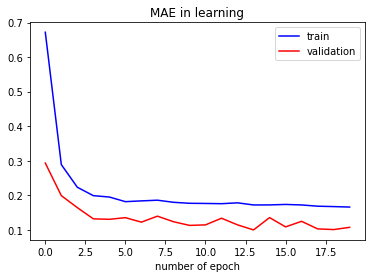

In [174]:
plt.plot(result[0]["loss"], 'b')
plt.plot(result[0]["val_loss"], 'r')
plt.xlabel("number of epoch")
plt.title("MAE in learning")
plt.legend(["train", "validation"])